In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import pandas as pd
from scipy.constants import c
from scipy.integrate import quad

#Nested sampling package
import ultranest
import corner

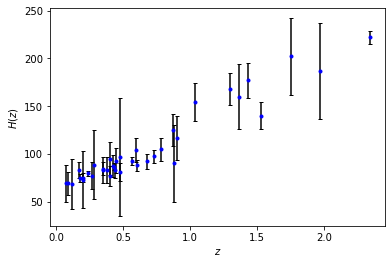

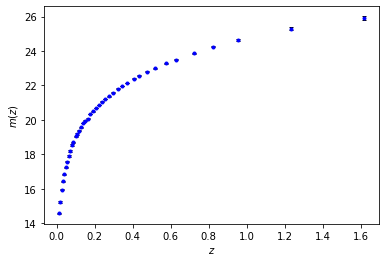

In [2]:
# Import Hubble H(z) data

hubble_data = pd.read_csv('hubble_data.csv', header=0)

z_H = np.array(hubble_data['z'])
H = np.array(hubble_data['H'])
dH = np.array(hubble_data['dH'])

plt.figure()
plt.errorbar(z_H, H, yerr=dH, marker = '.', color='blue', ecolor='black', capsize=2, ls='none')
plt.ylabel(r'$H(z)$')
plt.xlabel(r'$z$')
plt.show()

# Import apparent magnitude m(z) data
m_data = pd.read_csv('m_data.txt', sep = ' ', header = 0)
m_sys_unc = pd.read_csv('m_sys_unc.txt', sep = ' ', header = 0)
m_sys_unc = np.array(m_sys_unc['40']).reshape(40, 40)

tot = m_sys_unc + np.diag(m_data['dmb']**2)

z_m = np.array(m_data['zcmb'])
m = np.array(m_data['mb'])
dm = np.sqrt(np.diag(tot))

plt.figure()
plt.errorbar(z_m, m, yerr=dm, marker = '.', color='blue', ecolor='black', capsize=2, ls='none')
plt.ylabel(r'$m(z)$')
plt.xlabel(r'$z$')
plt.show()

# Combine redshifts for likelihood computation later
combined_z = []
combined_z.append(z_H)
combined_z.append(z_m)

# Combine data
combined_data = []
combined_data.append(H)
combined_data.append(m)

# Combine uncertainties
combined_unc = []
combined_unc.append(dH)
combined_unc.append(dm)

In [3]:
'Define logarithmic Model'
def logarithmic(z, params):
    H0 = params[0] 
    b = params[1] 
    f=b*np.log(1/(1+z)) + 1 
    return H0*np.sqrt(f*(1+z)**3)

'Define backreaction Model'
def backreaction(z, params):
    H0 = params[0] 
    OM = params[1] 
    n = params[2]
    
    return H0*np.sqrt(OM*((1+z)**3)+(1-OM)*((1+z)**n))

'Define apparent magnitude function'
def ApparentMagnitude(z, Hubble, params):
    
    def integrand_dl(z, Hubble, params):
    #integrand of luminosity distance formula
        return params[0]/Hubble(z, params)

    def dl(z, Hubble, params):
    #dimensionless luminosity distance at redshift z (input array)
        rz_array = np.zeros(len(z))
        for i in np.arange(len(z)):
            rz_each = quad( integrand_dl, 0, z[i],
                        args = (Hubble, params) )[0]
            rz_array[i] = rz_each
            
        return (1+z)*rz_array
    
    return 5*np.log10((c*100/params[0])*dl(z, Hubble, params)) - 19.25

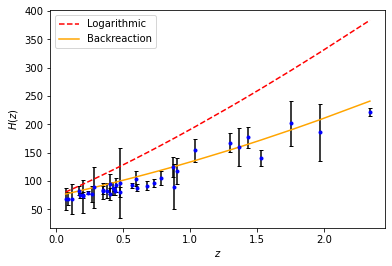

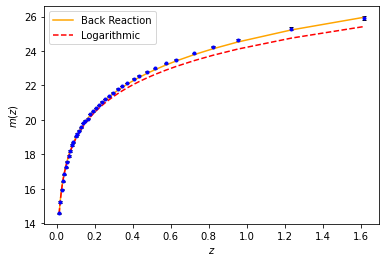

In [6]:
params_logarithmic = [73.37, 0.22]
params_backreaction = [73.37, 0.22, 1]

plt.figure()
plt.errorbar(z_H, H, yerr=dH, marker = '.', color='blue', ecolor='black', capsize=2, ls='none')
plt.plot(z_H, logarithmic(z_H, params_logarithmic), color='red', ls='--', label='Logarithmic')
plt.plot(z_H, backreaction(z_H, params_backreaction), color='orange', label='Backreaction')
plt.legend(loc='best')
plt.ylabel(r'$H(z)$')
plt.xlabel(r'$z$')
plt.show()

plt.figure()
plt.errorbar(z_m, m, yerr=dm, marker = '.', color='blue', ecolor='black', capsize=2, ls='none')
plt.plot(z_m, ApparentMagnitude(z_m, backreaction, params_backreaction), color='orange', label='Back Reaction')
plt.plot(z_m, ApparentMagnitude(z_m, logarithmic, params_logarithmic), color='red', ls='--', label='Logarithmic')
plt.legend(loc='best')
plt.ylabel(r'$m(z)$')
plt.xlabel(r'$z$')
plt.show()

In [7]:
# Logarithmic
def Prior_log(cube):

    #H0 Prior: [0,100]
    H0_min = 0
    H0_max = 100
    
    #b Prior: [0,1]
    b_min = 0
    b_max = 0.8
    
    #Extract values
    H0prime = cube[0]
    bprime = cube[1]
        
    H0 = H0prime*(H0_max-H0_min) + H0_min
    b = bprime*(b_max-b_min) + b_min
        
    return np.array([H0, b])
    
def LogLikelihood_log(params):
        

    # calculate the model
    hubble_model = logarithmic(z_H, params)
    apparent_magnitude_model = ApparentMagnitude(z_m, logarithmic, params)
        
    #calculate the likelihood
    residual_H = H - hubble_model
    residual_m = m - apparent_magnitude_model
    sig_H = 1/dH
    sig_m = 1/dm
        
    lnL_H = -0.5*np.sum((residual_H*sig_H)**2)
    lnL_m = -0.5*np.sum((residual_m*sig_m)**2)

    return  lnL_H + lnL_m 

In [8]:
t_i = time()
sampler_log = ultranest.ReactiveNestedSampler(['H0', 'b'], LogLikelihood_log, Prior_log)
result_log = sampler_log.run()
sampler_log.print_results()
t_f = time()

print('Sampling time: {} s'.format(t_f-t_i))

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3e+02  .70 [-258.7123..-258.7123]*| it/evals=5529/7581 eff=76.9948% N=400 0   00   
[ultranest] Likelihood function evaluations: 7588
[ultranest]   logZ = -267.9 +- 0.09277
[ultranest] Effective samples strategy satisfied (ESS = 1585.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.23, need <0.5)
[ultranest]   logZ error budget: single: 0.14 bs:0.09 tail:0.01 total:0.09 required:<0.50
[ultranest] done iterating.

logZ = -267.938 +- 0.232
  single instance: logZ = -267.938 +- 0.144
  bootstrapped   : logZ = -267.930 +- 0.232
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    H0                  68.47 +- 0.15
    b                   0.6828 +- 0.0097
Sampling time: 78.71536588668823 s


In [9]:
points_log = np.array(result_log["weighted_samples"]["points"])
weights_log = np.array(result_log["weighted_samples"]["weights"])
scaledweights_log = weights_log / weights_log.max()
mask_log = np.random.rand(len(scaledweights_log)) < scaledweights_log

samples_log = points_log[mask_log, :]

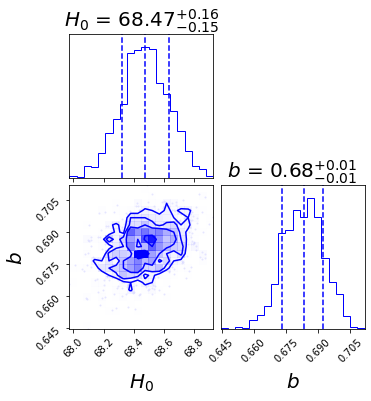

In [11]:
# Open saved samples
def open_samples(file):
    
    chains = pd.read_csv(file)
    nparams = len(chains.columns)
    
    if nparams == 2:
        samples = np.vstack((np.array(chains.iloc[:, 0]), np.array(chains.iloc[:, 1]))).T
    if nparams == 3:
        samples = np.vstack((np.array(chains.iloc[:, 0]), np.array(chains.iloc[:, 1]), np.array(chains.iloc[:, 2]))).T
    if nparams == 4:
        samples = np.vstack((np.array(chains.iloc[:, 0]), np.array(chains.iloc[:, 1]), np.array(chains.iloc[:, 2]), np.array(chains.iloc[:, 3]))).T
    
    return samples

# Extract and compile chains
logarithmic_chain_1 = samples_log[:,0] # extract chain of H0 values
logarithmic_chain_2 = samples_log[:,1] # extract chain if OM values
#logarithmic_chain_3 = samples_log[:,2] # extract chain if OL values
logarithmic_samples = np.vstack((logarithmic_chain_1, logarithmic_chain_2)).T

# Save chains and evidence (do not forget)
np.savetxt('logarithmic.csv', logarithmic_samples, delimiter=",")
np.savetxt('logarithmicz.csv', [[result_log['logz'] , result_log['logzerr']]])

# Open saved chains
samples_open =  open_samples('logarithmic.csv')


fig = corner.corner(samples_open, labels=[r"$H_0$", r"$b$", r"$\Omega_d$"],color='blue', label_kwargs={"fontsize": 20},quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 20})
fig.savefig('logarithmic.pdf')

In [12]:
# Back Reaction
def Prior_bc(cube):

    #H0 Prior: [0,100]
    H0_min = 0
    H0_max = 100
    
    #OM Prior: [0,1]
    OM_min = 0
    OM_max = 1
    
    #n Prior: [-4,4]
    n_min = -4
    n_max = 4
    
    #Extract values
    H0prime = cube[0]
    OMprime = cube[1]
    nprime = cube[2]
        
    H0 = H0prime*(H0_max-H0_min) + H0_min
    OM = OMprime*(OM_max-OM_min) + OM_min
    n = nprime*(n_max-n_min) + n_min
        
    return np.array([H0, OM, n])
    
def LogLikelihood_bc(params):
        

    # calculate the model
    hubble_model = backreaction(z_H, params)
    apparent_magnitude_model = ApparentMagnitude(z_m, backreaction, params)
        
    #calculate the likelihood
    residual_H = H - hubble_model
    residual_m = m - apparent_magnitude_model
    sig_H = 1/dH
    sig_m = 1/dm
        
    lnL_H = -0.5*np.sum((residual_H*sig_H)**2)
    lnL_m = -0.5*np.sum((residual_m*sig_m)**2)

    return  lnL_H + lnL_m 

In [13]:
t_i = time()
sampler_bc = ultranest.ReactiveNestedSampler(['H0', 'OM', 'n'], LogLikelihood_bc, Prior_bc)
result_bc = sampler_bc.run()
sampler_bc.print_results()
t_f = time()

print('Sampling time: {} s'.format(t_f-t_i))

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-4e+01   [-36.5021..-36.5020]*| it/evals=6619/13270 eff=51.4297% N=400        00   0 
[ultranest] Likelihood function evaluations: 13270
[ultranest]   logZ = -48.41 +- 0.1117
[ultranest] Effective samples strategy satisfied (ESS = 1834.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.29, need <0.5)
[ultranest]   logZ error budget: single: 0.16 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.

logZ = -48.422 +- 0.262
  single instance: logZ = -48.422 +- 0.162
  bootstrapped   : logZ = -48.413 +- 0.262
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    H0                  73.52 +- 0.33
    OM                  0.230 +- 0.018
    n                   0.23 +- 0.17
Sampling time: 140.41255617141724 s


In [14]:
points_bc = np.array(result_bc["weighted_samples"]["points"])
weights_bc = np.array(result_bc["weighted_samples"]["weights"])
scaledweights_bc = weights_bc / weights_bc.max()
mask_bc = np.random.rand(len(scaledweights_bc)) < scaledweights_bc

samples_bc = points_bc[mask_bc, :]

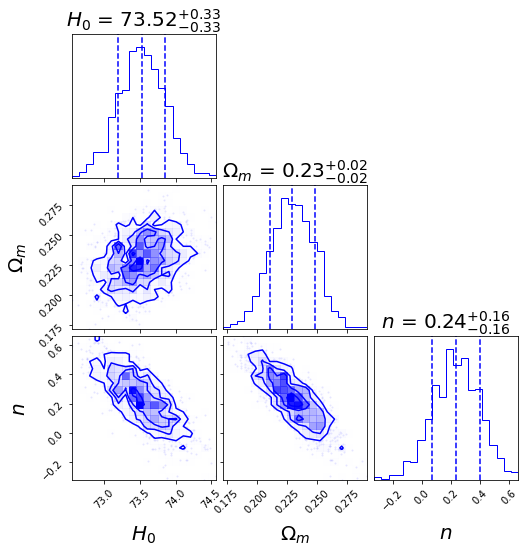

In [15]:
# Open saved samples
def open_samples(file):
    
    chains = pd.read_csv(file)
    nparams = len(chains.columns)
    
    if nparams == 2:
        samples = np.vstack((np.array(chains.iloc[:, 0]), np.array(chains.iloc[:, 1]))).T
    if nparams == 3:
        samples = np.vstack((np.array(chains.iloc[:, 0]), np.array(chains.iloc[:, 1]), np.array(chains.iloc[:, 2]))).T
    if nparams == 4:
        samples = np.vstack((np.array(chains.iloc[:, 0]), np.array(chains.iloc[:, 1]), np.array(chains.iloc[:, 2]), np.array(chains.iloc[:, 3]))).T
    
    return samples

# Extract and compile chains
backreaction_chain_1 = samples_bc[:,0] # extract chain of H0 values
backreaction_chain_2 = samples_bc[:,1] # extract chain if OM values
backreaction_chain_3 = samples_bc[:,2] # extract chain if n values
backreaction_samples = np.vstack((backreaction_chain_1, backreaction_chain_2, backreaction_chain_3)).T

# Save chains and evidence (do not forget)
np.savetxt('backreaction.csv', backreaction_samples, delimiter=",")
np.savetxt('backreactionz.csv', [[result_bc['logz'] , result_bc['logzerr']]])

# Open saved chains
samples_open =  open_samples('backreaction.csv')


fig = corner.corner(samples_open, labels=[r"$H_0$", r"$\Omega_m$", r"$n$"],color='blue', label_kwargs={"fontsize": 20},quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 20})
fig.savefig('backreaction.pdf')